<a href="https://colab.research.google.com/github/ConstancaVeiga/Blackjack_RL/blob/main/QLearningBlackJack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# BlackJack Environment Without Splitting

In [ ]:
class BlackjackGame:

    heart = "\u2665"
    spade = "\u2660"
    diamond = "\u2666"
    club = "\u2663"

    suits = {
        "diamonds": diamond,
        "hearts": heart,
        "spades": spade,
        "clubs": club
    }

    def __init__(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = []
        self.dealer_hand = []

    @staticmethod
    def generate_deck():
        numbers = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        deck = [{'number': number, 'suit': suit} for number in numbers for suit in suits]
        return deck

    def deal_card(self):
        return self.deck.pop()

    def start_game(self):
        self.player_hand = [self.deal_card(), self.deal_card()]
        self.dealer_hand = [self.deal_card(), self.deal_card()]

    @staticmethod
    def hand_value(hand):
        value = 0
        aces = 0
        for card in hand:
            if card['number'] in ['J', 'Q', 'K']:
                value += 10
            elif card['number'] == 'A':
                value += 11
                aces += 1
            else:
                value += int(card['number'])

        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def player_action(self, action):
        if action == "hit":
            self.player_hand.append(self.deal_card())
        return self.game_status()

    def dealer_action(self, output=False):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deal_card())
            if output:
                # print("Dealer hits and has:", self.format_cards(self.dealer_hand), self.hand_value(self.dealer_hand))
                pass

    def game_status(self):
        player_value = self.hand_value(self.player_hand)
        if player_value > 21:
            return "player_bust"
        elif player_value == 21:
            return "player_blackjack"
        else:
            return "continue"

    def game_result(self):
        self.dealer_action()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if player_value > 21:
            return "loss"
        elif dealer_value > 21 or player_value > dealer_value:
            return "win"
        elif player_value == dealer_value:
            return "draw"
        else:
            return "loss"

    @staticmethod
    def format_cards(cards):
        result = ""
        for card in cards:
            suit = BlackjackGame.suits[card["suit"]]
            result += f"{card['number']}{suit} "

        return result.strip()

# Q-Learning Algorithm

In [ ]:
class BlackjackQLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table
        self.Q = np.zeros((33, 12, 2, 2))  # Player sum, dealer card, action

    def choose_action(self, player_sum, dealer_card, usable_ace):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(["hit", "stay"])
        else:
            return "hit" if self.Q[player_sum, dealer_card, usable_ace, 0] > self.Q[player_sum, dealer_card, usable_ace, 1] else "stay"

    def update(self, player_sum, dealer_card, usable_ace, action, reward, new_player_sum, new_dealer_card, new_usable_ace):
        action_idx = 0 if action == "hit" else 1
        old_value = self.Q[player_sum, dealer_card, usable_ace, action_idx]
        future_max = np.max(self.Q[new_player_sum, new_dealer_card, new_usable_ace])
        self.Q[player_sum, dealer_card, usable_ace, action_idx] = old_value + self.alpha * (reward + self.gamma * future_max - old_value)

    @staticmethod
    def has_usable_ace(hand):
        """Check if the hand has a usable ace."""
        value, ace = 0, False
        for card in hand:
            card_number = card['number']
            value += min(10, int(card_number) if card_number not in ['J', 'Q', 'K', 'A'] else 11)
            ace |= (card_number == 'A')
        return int(ace and value + 10 <= 21)

    def train(self, episodes):
        one_percent = round(episodes / 100)

        for ep in range(episodes):
            game = BlackjackGame()
            game.start_game()

            if ep % one_percent == 0:
                progress = (ep/episodes) * 100
                print(f"Training progress: {progress:.2f}%")


            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            status = "continue"

            while status == "continue":
                player_sum = game.hand_value(game.player_hand)
                usable_ace = self.has_usable_ace(game.player_hand)
                action = self.choose_action(player_sum, dealer_card, usable_ace)
                status = game.player_action(action)
                new_player_sum = game.hand_value(game.player_hand)
                new_usable_ace = self.has_usable_ace(game.player_hand)

                reward = 0  # Intermediate reward, only final matters

                if status == "player_blackjack":
                    reward = 1
                elif status == "player_bust":
                    reward = -1

                if reward != 0:
                    self.update(player_sum, dealer_card, usable_ace, action, reward, new_player_sum, dealer_card, new_usable_ace)

                if action == "stay":
                    break

            final_result = game.game_result()
            final_reward = 1 if final_result == "win" else (-1 if final_result == "loss" else 0)
            self.update(player_sum, dealer_card, usable_ace, action, final_reward, new_player_sum, dealer_card, new_usable_ace)

    def play(self):
        game = BlackjackGame()
        game.start_game()

        # print("Dealer shows:", game.format_cards(game.dealer_hand[:1]))

        status = "continue"
        # print(game.format_cards(game.player_hand), game.hand_value(game.player_hand))
        while status == "continue":
            player_sum = game.hand_value(game.player_hand)
            usable_ace = self.has_usable_ace(game.player_hand)
            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            action = "hit" if self.Q[player_sum, dealer_card, usable_ace, 0] > self.Q[player_sum, dealer_card, usable_ace, 1] else "stay"
            status = game.player_action(action)

            if action == "stay":
                break

            # print(game.format_cards(game.player_hand), game.hand_value(game.player_hand))


        if status == "continue":
            # print("Dealer has:", game.format_cards(game.dealer_hand), game.hand_value(game.dealer_hand))
            game.dealer_action()

        final_result = game.game_result()
        return final_result

## Training

In [ ]:
# Train the agent
agent_q = BlackjackQLearning()
episodes = 5000000
agent_q.train(episodes)

Training progress: 0.00%
Training progress: 1.00%
Training progress: 2.00%
Training progress: 3.00%
Training progress: 4.00%
Training progress: 5.00%
Training progress: 6.00%
Training progress: 7.00%
Training progress: 8.00%
Training progress: 9.00%
Training progress: 10.00%
Training progress: 11.00%
Training progress: 12.00%
Training progress: 13.00%
Training progress: 14.00%
Training progress: 15.00%
Training progress: 16.00%
Training progress: 17.00%
Training progress: 18.00%
Training progress: 19.00%
Training progress: 20.00%
Training progress: 21.00%
Training progress: 22.00%
Training progress: 23.00%
Training progress: 24.00%
Training progress: 25.00%
Training progress: 26.00%
Training progress: 27.00%
Training progress: 28.00%
Training progress: 29.00%
Training progress: 30.00%
Training progress: 31.00%
Training progress: 32.00%
Training progress: 33.00%
Training progress: 34.00%
Training progress: 35.00%
Training progress: 36.00%
Training progress: 37.00%
Training progress: 38.

In [ ]:
# Test the agent's performance
test_games = 100000
wins_q = 0
losses_q = 0
draws_q = 0

cum_winrate = []

for _ in range(test_games):
    result = agent_q.play()
    if result == "win":
        wins_q += 1
        cum_winrate.append(wins_q/(wins_q + losses_q)*100)
    elif result == "loss":
        losses_q += 1
        cum_winrate.append(wins_q/(wins_q + losses_q)*100)
    else:
        draws_q += 1


In [ ]:
print(f"Wins: {wins_q}, Losses: {losses_q}, Draws: {draws_q}")
print(f"Win rate: {wins_q/(wins_q + losses_q)*100:.2f}%")

Wins: 37615, Losses: 54520, Draws: 7865
Win rate: 40.83%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

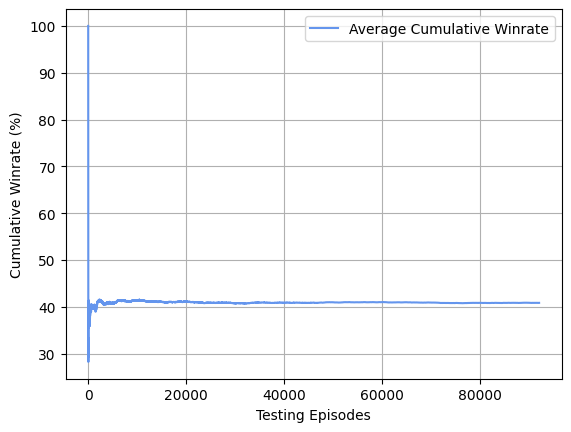

In [ ]:
plt.plot(np.arange(len(cum_winrate)), cum_winrate, label="Average Cumulative Winrate", c="cornflowerblue")
plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/QLearningCumWinRateNoSplitFull-LR0.1-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

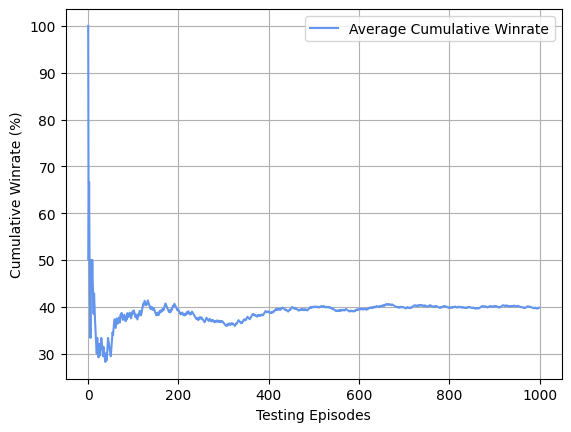

In [ ]:
plt.plot(np.arange(len(cum_winrate))[:1000], cum_winrate[:1000], label="Average Cumulative Winrate", c="cornflowerblue")
plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/QLearningCumWinRateNoSplitTrunc-LR0.1-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

# QV Learning Algorithm


In [ ]:
class BlackjackQVLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table and V-vector
        self.Q = np.zeros((33, 12, 2, 2))  # Player sum, dealer card, usable ace, action
        self.V = np.zeros((33, 12, 2))     # Player sum, dealer card, usable ace

    def choose_action(self, player_sum, dealer_card, usable_ace):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(["hit", "stay"])
        else:
            return "hit" if self.Q[player_sum, dealer_card, usable_ace, 0] > self.Q[player_sum, dealer_card, usable_ace, 1] else "stay"

    def update(self, player_sum, dealer_card, usable_ace, action, reward, new_player_sum, new_dealer_card, new_usable_ace):
        action_idx = 0 if action == "hit" else 1
        old_q_value = self.Q[player_sum, dealer_card, usable_ace, action_idx]

        # V(s') update
        new_v_value = self.V[new_player_sum, new_dealer_card, new_usable_ace]
        old_v_value = self.V[player_sum, dealer_card, usable_ace]
        self.V[player_sum, dealer_card, usable_ace] = old_v_value + self.alpha * (reward + self.gamma * new_v_value - old_v_value)

        # Q(s, a) update using V(s')
        self.Q[player_sum, dealer_card, usable_ace, action_idx] = old_q_value + self.alpha * (reward + self.gamma * new_v_value - old_q_value)

    @staticmethod
    def has_usable_ace(hand):
        """Check if the hand has a usable ace."""
        value, ace = 0, False
        for card in hand:
            card_number = card['number']
            value += min(10, int(card_number) if card_number not in ['J', 'Q', 'K', 'A'] else 11)
            ace |= (card_number == 'A')
        return int(ace and value + 10 <= 21)

    def train(self, episodes):
        one_percent = round(episodes / 100)

        for ep in range(episodes):
            game = BlackjackGame()
            game.start_game()

            if ep % one_percent == 0:
                progress = (ep / episodes) * 100
                print(f"Training progress: {progress:.2f}%")

            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            status = "continue"

            while status == "continue":
                player_sum = game.hand_value(game.player_hand)
                usable_ace = self.has_usable_ace(game.player_hand)
                action = self.choose_action(player_sum, dealer_card, usable_ace)
                status = game.player_action(action)
                new_player_sum = game.hand_value(game.player_hand)
                new_usable_ace = self.has_usable_ace(game.player_hand)

                reward = 0  # Intermediate reward, only final matters

                if status == "player_blackjack":
                    reward = 1
                elif status == "player_bust":
                    reward = -1

                if reward != 0:
                    self.update(player_sum, dealer_card, usable_ace, action, reward, new_player_sum, dealer_card, new_usable_ace)

                if action == "stay":
                    break

            final_result = game.game_result()
            final_reward = 1 if final_result == "win" else (-1 if final_result == "loss" else 0)
            self.update(player_sum, dealer_card, usable_ace, action, final_reward, new_player_sum, dealer_card, new_usable_ace)

    def play(self):
        game = BlackjackGame()
        game.start_game()

        # print("Dealer shows:", game.format_cards(game.dealer_hand[:1]))

        status = "continue"
        # print(game.format_cards(game.player_hand), game.hand_value(game.player_hand))
        while status == "continue":
            player_sum = game.hand_value(game.player_hand)
            usable_ace = self.has_usable_ace(game.player_hand)
            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            action = "hit" if self.Q[player_sum, dealer_card, usable_ace, 0] > self.Q[player_sum, dealer_card, usable_ace, 1] else "stay"
            status = game.player_action(action)

            if action == "stay":
                break

            # print(game.format_cards(game.player_hand), game.hand_value(game.player_hand))

        if status == "continue":
            # print("Dealer has:", game.format_cards(game.dealer_hand), game.hand_value(game.dealer_hand))
            game.dealer_action()

        final_result = game.game_result()
        return final_result

In [ ]:
# Train the agent
agent_qv = BlackjackQVLearning()
episodes = 5000000
agent_qv.train(episodes)

Training progress: 0.00%
Training progress: 1.00%
Training progress: 2.00%
Training progress: 3.00%
Training progress: 4.00%
Training progress: 5.00%
Training progress: 6.00%
Training progress: 7.00%
Training progress: 8.00%
Training progress: 9.00%
Training progress: 10.00%
Training progress: 11.00%
Training progress: 12.00%
Training progress: 13.00%
Training progress: 14.00%
Training progress: 15.00%
Training progress: 16.00%
Training progress: 17.00%
Training progress: 18.00%
Training progress: 19.00%
Training progress: 20.00%
Training progress: 21.00%
Training progress: 22.00%
Training progress: 23.00%
Training progress: 24.00%
Training progress: 25.00%
Training progress: 26.00%
Training progress: 27.00%
Training progress: 28.00%
Training progress: 29.00%
Training progress: 30.00%
Training progress: 31.00%
Training progress: 32.00%
Training progress: 33.00%
Training progress: 34.00%
Training progress: 35.00%
Training progress: 36.00%
Training progress: 37.00%
Training progress: 38.

In [ ]:
# Test the agent's performance
test_games = 100000
wins_qv = 0
losses_qv = 0
draws_qv = 0

cum_winrate_qv = []

for _ in range(test_games):
    result = agent_qv.play()
    if result == "win":
        wins_qv += 1
        cum_winrate_qv.append(wins_qv/(wins_qv + losses_qv)*100)
    elif result == "loss":
        losses_qv += 1
        cum_winrate_qv.append(wins_qv/(wins_qv + losses_qv)*100)
    else:
        draws_qv += 1


In [ ]:
print(f"Wins: {wins_qv}, Losses: {losses_qv}, Draws: {draws_qv}")
print(f"Win rate: {wins_qv/(wins_qv + losses_qv)*100:.2f}%")

Wins: 37838, Losses: 54440, Draws: 7722
Win rate: 41.00%


### Comparison with Q-Learning

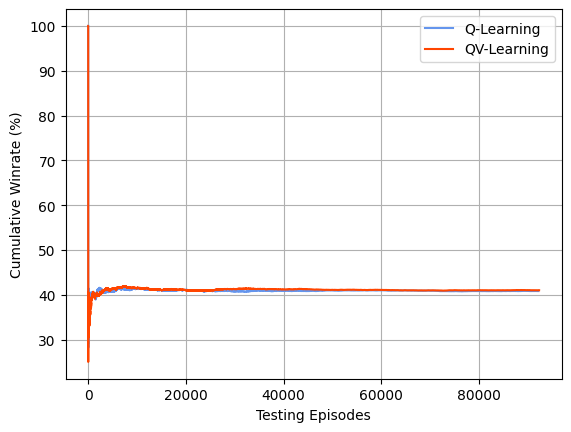

In [ ]:
plt.plot(np.arange(len(cum_winrate)), cum_winrate, label="Q-Learning", c="cornflowerblue")
plt.plot(np.arange(len(cum_winrate_qv)), cum_winrate_qv, label="QV-Learning", c="orangered")
plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/ComparisonCumWinRateNoSplitFull-LR0.1-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

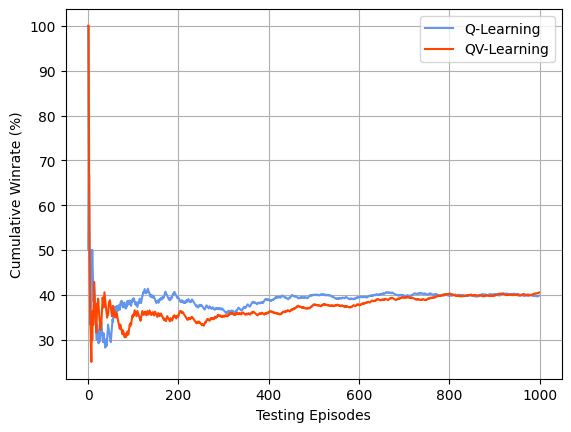

In [ ]:
plt.plot(np.arange(len(cum_winrate))[:1000], cum_winrate[:1000], label="Q-Learning", c="cornflowerblue")
plt.plot(np.arange(len(cum_winrate_qv))[:1000], cum_winrate_qv[:1000], label="QV-Learning", c="orangered")
plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/ComparisonCumWinRateNoSplitTrunc-LR0.1-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

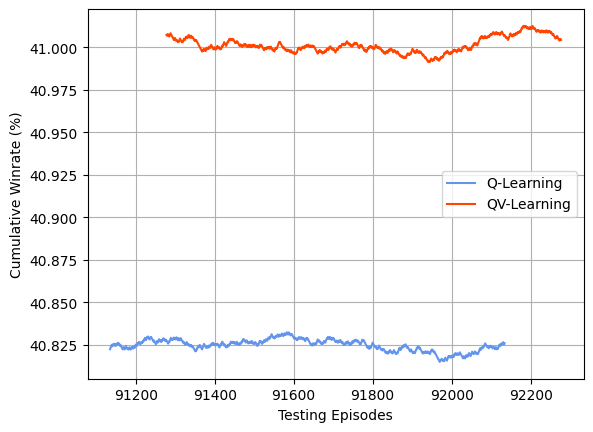

In [ ]:
plt.plot(np.arange(len(cum_winrate))[-1000:], cum_winrate[-1000:], label="Q-Learning", c="cornflowerblue")
plt.plot(np.arange(len(cum_winrate_qv))[-1000:], cum_winrate_qv[-1000:], label="QV-Learning", c="orangered")
plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/ComparisonCumWinRateNoSplitFinalEps-LR0.1-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

## Sensitivity Study


In [ ]:
def train_agent(alpha, episodes):
  agent_qv = BlackjackQVLearning(alpha=alpha)
  agent_qv.train(episodes)

  return agent_qv

In [ ]:
def test_agent(model, test_games):
  # test_games = 100000
  wins_qv = 0
  losses_qv = 0
  draws_qv = 0

  one_percent = round(test_games / 100)

  for idx in range(test_games):

      if idx % one_percent == 0:
          progress = (idx / test_games) * 100
          print(f"Testing progress: {progress:.2f}%")
      # print("-----")
      result = agent_qv.play()
      # print(result)
      if result == "win":
          wins_qv += 1
      elif result == "loss":
          losses_qv += 1
      else:
          draws_qv += 1

  return wins_qv, losses_qv, draws_qv

In [ ]:
def average_list(list):
  return sum(list)/len(list)

In [ ]:
alpha = np.arange(0.05, 0.16, 0.01)
gamma = 0.89

iterations = 3

win_rate = []

for a in alpha:
  print('Testing alpha = ', a)
  win_rate_tmp = []

  for idx in range(iterations):
    print(f'Iteration {idx} of alpha = {a}')
    np.random.seed(idx)

    agent_qv = train_agent(alpha=a, episodes=5000000)

    print("Running agent testing")

    wins_qv, losses_qv, draws_qv = test_agent(model=agent_qv, test_games=100000)

    print(f"Wins: {wins_qv}, Losses: {losses_qv}, Draws: {draws_qv}")
    print(f"Win rate: {wins_qv/(wins_qv + losses_qv)*100:.2f}%")

    win_rate_tmp.append(wins_qv/(wins_qv + losses_qv)*100)

  win_rate.append(average_list(win_rate_tmp))

  print(' ')

print(f'Alpha: {alpha}')
print(f'win_rates: {win_rate}')

Streaming output truncated to the last 5000 lines.
Testing progress: 17.00%
Testing progress: 18.00%
Testing progress: 19.00%
Testing progress: 20.00%
Testing progress: 21.00%
Testing progress: 22.00%
Testing progress: 23.00%
Testing progress: 24.00%
Testing progress: 25.00%
Testing progress: 26.00%
Testing progress: 27.00%
Testing progress: 28.00%
Testing progress: 29.00%
Testing progress: 30.00%
Testing progress: 31.00%
Testing progress: 32.00%
Testing progress: 33.00%
Testing progress: 34.00%
Testing progress: 35.00%
Testing progress: 36.00%
Testing progress: 37.00%
Testing progress: 38.00%
Testing progress: 39.00%
Testing progress: 40.00%
Testing progress: 41.00%
Testing progress: 42.00%
Testing progress: 43.00%
Testing progress: 44.00%
Testing progress: 45.00%
Testing progress: 46.00%
Testing progress: 47.00%
Testing progress: 48.00%
Testing progress: 49.00%
Testing progress: 50.00%
Testing progress: 51.00%
Testing progress: 52.00%
Testing progress: 53.00%
Testing progress: 54.00%

Running the above. To execute the next

In [ ]:
alpha = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1,  0.11, 0.12, 0.13, 0.14, 0.15]
win_rates = [41.678581646377395, 41.50972132992829, 41.956392657540455, 41.93974737616626, 40.813534477503524, 40.021653553031115, 41.35608255303342, 42.06754118633868, 40.34377364003922, 40.795772608361055, 40.748505654651886]

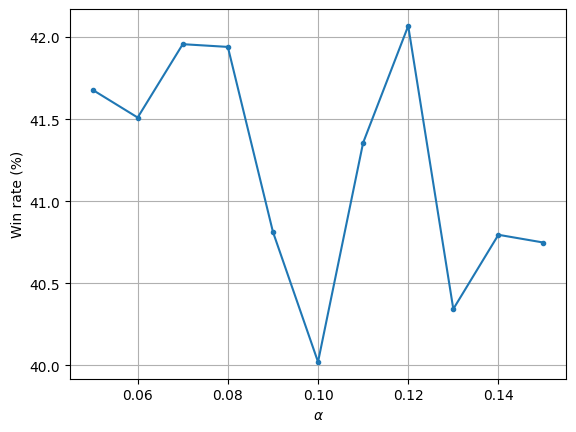

In [ ]:
import matplotlib.pyplot as plt

plt.plot(alpha, win_rates, marker=".")
plt.grid()
plt.xlabel(r'$\alpha$')
plt.ylabel('Win rate (%)')
plt.show()

Now, given we found an optimal α = 0.12, we can optimise over γ

In [ ]:
def train_agent(alpha, gamma, episodes):
  agent_qv = BlackjackQVLearning(alpha=alpha, gamma=gamma)
  agent_qv.train(episodes)

  return agent_qv

In [ ]:
alpha = 0.12 #np.arange(0.05, 0.16, 0.01)
gamma = np.arange(0.88, 0.99, 0.01)

iterations = 3

win_rate = []

for g in gamma:
  print('Testing gamma = ', g)
  win_rate_tmp = []

  for idx in range(iterations):
    print(f'Iteration {idx} of gamma = {g}')
    np.random.seed(idx)

    agent_qv = train_agent(alpha=alpha, gamma=g, episodes=5000000)

    print("Running agent testing")

    wins_qv, losses_qv, draws_qv = test_agent(model=agent_qv, test_games=100000)

    print(f"Wins: {wins_qv}, Losses: {losses_qv}, Draws: {draws_qv}")
    print(f"Win rate: {wins_qv/(wins_qv + losses_qv)*100:.2f}%")

    win_rate_tmp.append(wins_qv/(wins_qv + losses_qv)*100)

  win_rate.append(average_list(win_rate_tmp))

  print(' ')

print(f'Gamma: {gamma}')
print(f'win_rates: {win_rate}')

Streaming output truncated to the last 5000 lines.
Testing progress: 17.00%
Testing progress: 18.00%
Testing progress: 19.00%
Testing progress: 20.00%
Testing progress: 21.00%
Testing progress: 22.00%
Testing progress: 23.00%
Testing progress: 24.00%
Testing progress: 25.00%
Testing progress: 26.00%
Testing progress: 27.00%
Testing progress: 28.00%
Testing progress: 29.00%
Testing progress: 30.00%
Testing progress: 31.00%
Testing progress: 32.00%
Testing progress: 33.00%
Testing progress: 34.00%
Testing progress: 35.00%
Testing progress: 36.00%
Testing progress: 37.00%
Testing progress: 38.00%
Testing progress: 39.00%
Testing progress: 40.00%
Testing progress: 41.00%
Testing progress: 42.00%
Testing progress: 43.00%
Testing progress: 44.00%
Testing progress: 45.00%
Testing progress: 46.00%
Testing progress: 47.00%
Testing progress: 48.00%
Testing progress: 49.00%
Testing progress: 50.00%
Testing progress: 51.00%
Testing progress: 52.00%
Testing progress: 53.00%
Testing progress: 54.00%

In [ ]:
gamma =  [0.88, 0.89, 0.9,  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98]
win_rates = [40.963345480457434, 41.82035974449786, 41.330546762082605, 41.492530276404096, 40.54576571269862, 41.03874335320247, 41.23203826325365, 41.06479636034001, 40.62343054416035, 41.59060211134196, 40.99807231798071]

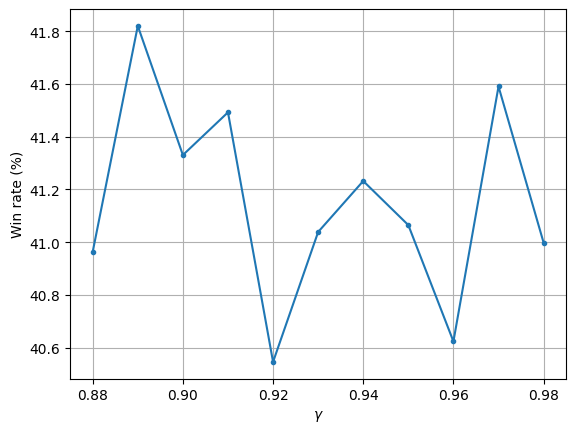

In [ ]:
import matplotlib.pyplot as plt

plt.plot(gamma, win_rates, marker=".")
plt.grid()
plt.xlabel(r'$\gamma$')
plt.ylabel('Win rate (%)')
plt.show()

## Adding Splitting to Environment


In [ ]:
import random
import numpy as np

In [ ]:
class BlackjackGame:

    heart = "\u2665"
    spade = "\u2660"
    diamond = "\u2666"
    club = "\u2663"

    suits = {
        "diamonds": diamond,
        "hearts": heart,
        "spades": spade,
        "clubs": club
    }

    def __init__(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hands = [[]]  # Multiple hands for splitting
        self.dealer_hand = []
        self.current_hand = 0

    @staticmethod
    def generate_deck():
        numbers = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        deck = [{'number': number, 'suit': suit} for number in numbers for suit in suits]
        return deck

    def deal_card(self):
        return self.deck.pop()

    def start_game(self):
        self.player_hands = [[self.deal_card(), self.deal_card()]]  # Start with one hand
        self.dealer_hand = [self.deal_card(), self.deal_card()]
        self.current_hand = 0

    @staticmethod
    def hand_value(hand):
        value = 0
        aces = 0
        for card in hand:
            if card['number'] in ['J', 'Q', 'K']:
                value += 10
            elif card['number'] == 'A':
                value += 11
                aces += 1
            else:
                value += int(card['number'])

        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def player_action(self, action):
        current_hand = self.player_hands[self.current_hand]
        if action == "hit":
            current_hand.append(self.deal_card())
        elif action == "split" and len(current_hand) == 2 and current_hand[0]['number'] == current_hand[1]['number']:
            self.player_hands.append([self.player_hands[self.current_hand].pop()])
            self.player_hands[self.current_hand].append(self.deal_card())
            self.player_hands[-1].append(self.deal_card())

        return self.game_status()

    def dealer_action(self, output=False):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deal_card())
            if output:
                print("Dealer hits and has:", self.format_cards(self.dealer_hand), self.hand_value(self.dealer_hand))

    def game_status(self):
        current_hand_value = self.hand_value(self.player_hands[self.current_hand])
        if current_hand_value > 21:
            return "player_bust"
        elif current_hand_value == 21:
            return "player_blackjack"
        else:
            return "continue"

    def game_result(self):
        self.dealer_action()
        results = []
        dealer_value = self.hand_value(self.dealer_hand)

        for hand in self.player_hands:
            player_value = self.hand_value(hand)
            if player_value > 21:
                results.append("loss")
            elif dealer_value > 21 or player_value > dealer_value:
                results.append("win")
            elif player_value == dealer_value:
                results.append("draw")
            else:
                results.append("loss")

        return results

    @staticmethod
    def format_cards(cards):
        result = ""
        for card in cards:
            suit = BlackjackGame.suits[card["suit"]]
            result += f"{card['number']}{suit} "

        return result.strip()

In [ ]:
class BlackjackQVLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table and V-vector
        self.Q = np.zeros((33, 12, 2, 3))  # Player sum, dealer card, usable ace, action (hit, stay, split)
        self.V = np.zeros((33, 12, 2))     # Player sum, dealer card, usable ace

    def choose_action(self, player_sum, dealer_card, usable_ace, can_split):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(["hit", "stay", "split"]) if can_split else np.random.choice(["hit", "stay"])
        else:
            if can_split:
                action_idx = np.argmax(self.Q[player_sum, dealer_card, usable_ace])
                return ["hit", "stay", "split"][action_idx]
            else:
                action_idx = np.argmax(self.Q[player_sum, dealer_card, usable_ace, :2])
                return ["hit", "stay"][action_idx]

    def update(self, player_sum, dealer_card, usable_ace, action, reward, new_player_sum, new_dealer_card, new_usable_ace):
        action_idx = ["hit", "stay", "split"].index(action)
        old_q_value = self.Q[player_sum, dealer_card, usable_ace, action_idx]

        # V(s') update
        new_v_value = self.V[new_player_sum, new_dealer_card, new_usable_ace]
        old_v_value = self.V[player_sum, dealer_card, usable_ace]
        self.V[player_sum, dealer_card, usable_ace] = old_v_value + self.alpha * (reward + self.gamma * new_v_value - old_v_value)

        # Q(s, a) update using V(s')
        self.Q[player_sum, dealer_card, usable_ace, action_idx] = old_q_value + self.alpha * (reward + self.gamma * new_v_value - old_q_value)

    @staticmethod
    def has_usable_ace(hand):
        """Check if the hand has a usable ace."""
        value, ace = 0, False
        for card in hand:
            card_number = card['number']
            value += min(10, int(card_number) if card_number not in ['J', 'Q', 'K', 'A'] else 11)
            ace |= (card_number == 'A')
        return int(ace and value + 10 <= 21)

    def train(self, episodes):
        one_percent = round(episodes / 100)

        for ep in range(episodes):
            game = BlackjackGame()
            game.start_game()

            if ep % one_percent == 0:
                progress = (ep / episodes) * 100
                # print(f"Training progress: {progress:.2f}%")

            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            status = "continue"

            while status == "continue":
                player_sum = game.hand_value(game.player_hands[game.current_hand])
                usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])
                can_split = len(game.player_hands[game.current_hand]) == 2 and game.player_hands[game.current_hand][0]['number'] == game.player_hands[game.current_hand][1]['number']
                action = self.choose_action(player_sum, dealer_card, usable_ace, can_split)
                status = game.player_action(action)
                new_player_sum = game.hand_value(game.player_hands[game.current_hand])
                new_usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])

                reward = 0  # Intermediate reward, only final matters

                if status == "player_blackjack":
                    reward = 1
                elif status == "player_bust":
                    reward = -1

                if reward != 0:
                    self.update(player_sum, dealer_card, usable_ace, action, reward, new_player_sum, dealer_card, new_usable_ace)

                if action == "stay":
                    game.current_hand += 1
                    if game.current_hand >= len(game.player_hands):
                        break

            final_results = game.game_result()
            for result in final_results:
                final_reward = 1 if result == "win" else (-1 if result == "loss" else 0)
                self.update(player_sum, dealer_card, usable_ace, action, final_reward, new_player_sum, dealer_card, new_usable_ace)

    def play(self):
        game = BlackjackGame()
        game.start_game()

        split_choices = 0
        split_opportunities = 0

        status = "continue"
        while status == "continue":
            player_sum = game.hand_value(game.player_hands[game.current_hand])
            usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])
            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            can_split = (
                len(game.player_hands[game.current_hand]) == 2 and
                game.player_hands[game.current_hand][0]['number'] == game.player_hands[game.current_hand][1]['number']
            )

            if can_split:
                split_opportunities += 1

            action = self.choose_action(player_sum, dealer_card, usable_ace, can_split)
            status = game.player_action(action)

            if action == "split":
              split_choices += 1

            if action == "stay":
                game.current_hand += 1
                if game.current_hand >= len(game.player_hands):
                    break

        final_results = game.game_result()

        return final_results, split_opportunities, split_choices

In [ ]:
# Train the agent
agent_qv = BlackjackQVLearning()
episodes = 500000  # Number of training episodes
agent_qv.train(episodes)

In [ ]:
# Test the agent's performance
test_games = 10000
wins_qv = 0
losses_qv = 0
draws_qv = 0
total_split_opportunities = 0
total_split_choices = 0

for idx in range(test_games):
    result, split_opportunities, split_choices = agent_qv.play()
    total_split_opportunities += split_opportunities
    total_split_choices += split_choices

    # Iterate over the results for each hand (including split hands)
    for outcome in result:
        if outcome == "win":
            wins_qv += 1
        elif outcome == "loss":
            losses_qv += 1
        else:
            draws_qv += 1

print(f"Wins: {wins_qv}, Losses: {losses_qv}, Draws: {draws_qv}")
print(f"Win rate: {wins_qv / (wins_qv + losses_qv) * 100:.2f}%")

# Output the split statistics
if total_split_opportunities > 0:
    print(f"Total split opportunities: {total_split_opportunities}")
    print(f"Total split choices: {total_split_choices}")
    print(f"Split percentage: {total_split_choices / total_split_opportunities * 100:.2f}%")
else:
    print("No split opportunities encountered during testing.")

Wins: 3638, Losses: 5864, Draws: 801
Win rate: 38.29%
Total split opportunities: 596
Total split choices: 303
Split percentage: 50.84%


### Sensitivity Study

In [ ]:
def train_agent(alpha, gamma, episodes):
  agent_qv = BlackjackQVLearning(alpha=alpha, gamma=gamma)
  agent_qv.train(episodes)

  return agent_qv

In [ ]:
def test_agent(model, test_games):
  # Test the agent's performance
  wins_qv = 0
  losses_qv = 0
  draws_qv = 0
  total_split_opportunities = 0
  total_split_choices = 0

  for idx in range(test_games):
      result, split_opportunities, split_choices = agent_qv.play()
      total_split_opportunities += split_opportunities
      total_split_choices += split_choices

      # Iterate over the results for each hand (including split hands)
      for outcome in result:
          if outcome == "win":
              wins_qv += 1
          elif outcome == "loss":
              losses_qv += 1
          else:
              draws_qv += 1

  return wins_qv, losses_qv, draws_qv, total_split_choices, total_split_opportunities

In [ ]:
def average_list(list):
  return sum(list)/len(list)

In [ ]:
def alpha_sweep(alpha, gamma, iterations):

  win_rate = []
  split_rate = []

  for a in alpha:
    # print('Testing alpha = ', a)
    win_rate_tmp = []
    split_rate_tmp = []

    for idx in range(iterations):
      # print(f'Iteration {idx} of alpha = {a}')
      np.random.seed(idx)

      # print("Training agent")
      agent_qv = train_agent(alpha=a, gamma=gamma, episodes=5000000) #5000000

      # print("Testing agent")

      wins_qv, losses_qv, draws_qv, total_split_choices, total_split_opportunities = test_agent(model=agent_qv, test_games=100000) #100000

      win_rate_tmp.append(wins_qv/(wins_qv + losses_qv)*100)
      split_rate_tmp.append(total_split_choices / total_split_opportunities * 100)

    win_rate.append(average_list(win_rate_tmp))
    split_rate.append(average_list(split_rate_tmp))

  return win_rate, split_rate


In [ ]:
def gamma_sweep(alpha, gamma, iterations):

  win_rate = []
  split_rate = []

  for g in gamma:
    # print('Testing gamma = ', g)
    win_rate_tmp = []
    split_rate_tmp = []

    for idx in range(iterations):
      # print(f'Iteration {idx} of alpha = {g}')
      np.random.seed(idx)

      # print("Training agent")
      agent_qv = train_agent(alpha=alpha, gamma=g, episodes=5000000)

      # print("Testing agent")

      wins_qv, losses_qv, draws_qv, total_split_choices, total_split_opportunities = test_agent(model=agent_qv, test_games=100000)

      win_rate_tmp.append(wins_qv/(wins_qv + losses_qv)*100)
      split_rate_tmp.append(total_split_choices / total_split_opportunities * 100)

    win_rate.append(average_list(win_rate_tmp))
    split_rate.append(average_list(split_rate_tmp))

  return win_rate, split_rate


In [ ]:
print("Experiment 1")
alpha_1 = np.arange(0.05, 0.16, 0.01)
gamma_1 = 0.9

win_rate1, split_rate1 = alpha_sweep(alpha_1, gamma_1, iterations=3)
print(f'Alpha: {alpha_1}')
print(f'Win rate: {win_rate1}')
print(f'Split rate: {split_rate1}')


max_win_rate1_idx = win_rate1.index(max(win_rate1))
alpha_1_opt = alpha_1[max_win_rate1_idx]
print(f'Optimal alpha: {alpha_1_opt}')
print('------------------------------------')
print(' ')

print("Experiment 2")
alpha_2 = alpha_1_opt
gamma_2 = np.arange(0.88, 0.99, 0.01)

win_rate2, split_rate2 = gamma_sweep(alpha_2, gamma_2, iterations=3)
print(f'Gamma: {gamma_2}')
print(f'Win rate: {win_rate2}')
print(f'Split rate: {split_rate2}')


max_win_rate2_idx = win_rate2.index(max(win_rate2))
gamma_2_opt = gamma_2[max_win_rate2_idx]
print(f'Optimal gamma: {gamma_2_opt}')
print('------------------------------------')
print(' ')

print("Experiment 3")
alpha_3 = np.arange(0.05, 0.16, 0.01)
gamma_3 = gamma_2_opt

win_rate3, split_rate3 = alpha_sweep(alpha_3, gamma_3, iterations=3)
print(f'Alpha: {alpha_3}')
print(f'Win rate: {win_rate3}')
print(f'Split rate: {split_rate3}')


max_win_rate3_idx = win_rate3.index(max(win_rate3))
alpha_3_opt = alpha_3[max_win_rate3_idx]
print(f'Optimal alpha: {alpha_3_opt}')
print('------------------------------------')
print(' ')

Experiment 1
Alpha: [0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14 0.15]
Win rate: [38.89874238962779, 38.73034239539161, 38.89337166872826, 39.066814285654964, 38.88264400840492, 38.930247288951016, 38.80599051847833, 38.90013691160485, 38.972421623737, 38.830097480716695, 38.79932225776469]
Split rate: [49.32887200514915, 48.9801732273278, 48.9139083038469, 49.5921703861576, 49.02043317204786, 49.244383587739925, 48.53261025343315, 49.672368842252666, 49.20170982009233, 49.0247112989994, 48.06920256207658]
Optimal alpha: 0.08000000000000002
------------------------------------
 
Experiment 2
Gamma: [0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98]
Win rate: [38.82993531856602, 38.81814722137158, 38.9818661108805, 38.966607755535904, 38.71167317434501, 38.939611847147425, 38.92580479354305, 38.94253441156234, 38.90083203181885, 38.66479163341801, 38.87256016978733]
Split rate: [49.12231413726008, 48.557662250311004, 48.876370067774836, 48.59947024509222, 48.57302555812898, 

# Final Training/Testing with Optimal Params

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

## Without Splitting

In [ ]:
class BlackjackGame:

    heart = "\u2665"
    spade = "\u2660"
    diamond = "\u2666"
    club = "\u2663"

    suits = {
        "diamonds": diamond,
        "hearts": heart,
        "spades": spade,
        "clubs": club
    }

    def __init__(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hand = []
        self.dealer_hand = []

    @staticmethod
    def generate_deck():
        numbers = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        deck = [{'number': number, 'suit': suit} for number in numbers for suit in suits]
        return deck

    def deal_card(self):
        return self.deck.pop()

    def start_game(self):
        self.player_hand = [self.deal_card(), self.deal_card()]
        self.dealer_hand = [self.deal_card(), self.deal_card()]

    @staticmethod
    def hand_value(hand):
        value = 0
        aces = 0
        for card in hand:
            if card['number'] in ['J', 'Q', 'K']:
                value += 10
            elif card['number'] == 'A':
                value += 11
                aces += 1
            else:
                value += int(card['number'])

        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def player_action(self, action):
        if action == "hit":
            self.player_hand.append(self.deal_card())
        return self.game_status()

    def dealer_action(self, output=False):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deal_card())
            if output:
                # print("Dealer hits and has:", self.format_cards(self.dealer_hand), self.hand_value(self.dealer_hand))
                pass

    def game_status(self):
        player_value = self.hand_value(self.player_hand)
        if player_value > 21:
            return "player_bust"
        elif player_value == 21:
            return "player_blackjack"
        else:
            return "continue"

    def game_result(self):
        self.dealer_action()
        player_value = self.hand_value(self.player_hand)
        dealer_value = self.hand_value(self.dealer_hand)

        if player_value > 21:
            return "loss"
        elif dealer_value > 21 or player_value > dealer_value:
            return "win"
        elif player_value == dealer_value:
            return "draw"
        else:
            return "loss"

    @staticmethod
    def format_cards(cards):
        result = ""
        for card in cards:
            suit = BlackjackGame.suits[card["suit"]]
            result += f"{card['number']}{suit} "

        return result.strip()

In [ ]:
class BlackjackQVLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Initialize Q-table and V-vector
        self.Q = np.zeros((33, 12, 2, 2))  # Player sum, dealer card, usable ace, action
        self.V = np.zeros((33, 12, 2))     # Player sum, dealer card, usable ace

    def choose_action(self, player_sum, dealer_card, usable_ace):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(["hit", "stay"])
        else:
            return "hit" if self.Q[player_sum, dealer_card, usable_ace, 0] > self.Q[player_sum, dealer_card, usable_ace, 1] else "stay"

    def update(self, player_sum, dealer_card, usable_ace, action, reward, new_player_sum, new_dealer_card, new_usable_ace):
        action_idx = 0 if action == "hit" else 1
        old_q_value = self.Q[player_sum, dealer_card, usable_ace, action_idx]

        # V(s') update
        new_v_value = self.V[new_player_sum, new_dealer_card, new_usable_ace]
        old_v_value = self.V[player_sum, dealer_card, usable_ace]
        self.V[player_sum, dealer_card, usable_ace] = old_v_value + self.alpha * (reward + self.gamma * new_v_value - old_v_value)

        # Q(s, a) update using V(s')
        self.Q[player_sum, dealer_card, usable_ace, action_idx] = old_q_value + self.alpha * (reward + self.gamma * new_v_value - old_q_value)

    @staticmethod
    def has_usable_ace(hand):
        """Check if the hand has a usable ace."""
        value, ace = 0, False
        for card in hand:
            card_number = card['number']
            value += min(10, int(card_number) if card_number not in ['J', 'Q', 'K', 'A'] else 11)
            ace |= (card_number == 'A')
        return int(ace and value + 10 <= 21)

    def train(self, episodes):
        one_percent = round(episodes / 100)

        for ep in range(episodes):
            game = BlackjackGame()
            game.start_game()

            if ep % one_percent == 0:
                progress = (ep / episodes) * 100
                print(f"Training progress: {progress:.2f}%")

            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            status = "continue"

            while status == "continue":
                player_sum = game.hand_value(game.player_hand)
                usable_ace = self.has_usable_ace(game.player_hand)
                action = self.choose_action(player_sum, dealer_card, usable_ace)
                status = game.player_action(action)
                new_player_sum = game.hand_value(game.player_hand)
                new_usable_ace = self.has_usable_ace(game.player_hand)

                reward = 0  # Intermediate reward, only final matters

                if status == "player_blackjack":
                    reward = 1
                elif status == "player_bust":
                    reward = -1

                if reward != 0:
                    self.update(player_sum, dealer_card, usable_ace, action, reward, new_player_sum, dealer_card, new_usable_ace)

                if action == "stay":
                    break

            final_result = game.game_result()
            final_reward = 1 if final_result == "win" else (-1 if final_result == "loss" else 0)
            self.update(player_sum, dealer_card, usable_ace, action, final_reward, new_player_sum, dealer_card, new_usable_ace)

    def play(self):
        game = BlackjackGame()
        game.start_game()

        # print("Dealer shows:", game.format_cards(game.dealer_hand[:1]))

        status = "continue"
        # print(game.format_cards(game.player_hand), game.hand_value(game.player_hand))
        while status == "continue":
            player_sum = game.hand_value(game.player_hand)
            usable_ace = self.has_usable_ace(game.player_hand)
            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            action = "hit" if self.Q[player_sum, dealer_card, usable_ace, 0] > self.Q[player_sum, dealer_card, usable_ace, 1] else "stay"
            status = game.player_action(action)

            if action == "stay":
                break

            # print(game.format_cards(game.player_hand), game.hand_value(game.player_hand))

        if status == "continue":
            # print("Dealer has:", game.format_cards(game.dealer_hand), game.hand_value(game.dealer_hand))
            game.dealer_action()

        final_result = game.game_result()
        return final_result

In [ ]:
def train_agent(alpha, gamma, episodes):
  agent_qv = BlackjackQVLearning(alpha=alpha, gamma=gamma)
  agent_qv.train(episodes)

  return agent_qv

In [ ]:
def test_agent(model, test_games):
  wins_qv = 0
  losses_qv = 0
  draws_qv = 0

  cum_winrate = np.zeros(test_games)

  for idx in range(test_games):
      result = agent_qv.play()
      if result == "win":
          wins_qv += 1
      elif result == "loss":
          losses_qv += 1
      else:
          draws_qv += 1

      cum_winrate[idx] = wins_qv/(wins_qv + losses_qv)*100

  return cum_winrate

In [ ]:
alpha = 0.12
gamma = 0.90

iterations = 3

cum_winrate_total = [[] for _ in range(iterations)]

for idx in range(iterations):
  np.random.seed(idx)
  agent_qv = train_agent(alpha=0.12, gamma=0.9, episodes=5000000)
  cum_winrate_tmp = test_agent(model=agent_qv, test_games=100000)
  cum_winrate_total[idx] = cum_winrate_tmp

cum_winrate_total_array = np.array(cum_winrate_total)

average_cum_winrate = np.mean(cum_winrate_total_array, axis=0)
std_cum_winrate = np.std(cum_winrate_total_array, axis=0)

test_games = np.arange(len(average_cum_winrate))

Training progress: 0.00%
Training progress: 1.00%
Training progress: 2.00%
Training progress: 3.00%
Training progress: 4.00%
Training progress: 5.00%
Training progress: 6.00%
Training progress: 7.00%
Training progress: 8.00%
Training progress: 9.00%
Training progress: 10.00%
Training progress: 11.00%
Training progress: 12.00%
Training progress: 13.00%
Training progress: 14.00%
Training progress: 15.00%
Training progress: 16.00%
Training progress: 17.00%
Training progress: 18.00%
Training progress: 19.00%
Training progress: 20.00%
Training progress: 21.00%
Training progress: 22.00%
Training progress: 23.00%
Training progress: 24.00%
Training progress: 25.00%
Training progress: 26.00%
Training progress: 27.00%
Training progress: 28.00%
Training progress: 29.00%
Training progress: 30.00%
Training progress: 31.00%
Training progress: 32.00%
Training progress: 33.00%
Training progress: 34.00%
Training progress: 35.00%
Training progress: 36.00%
Training progress: 37.00%
Training progress: 38.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


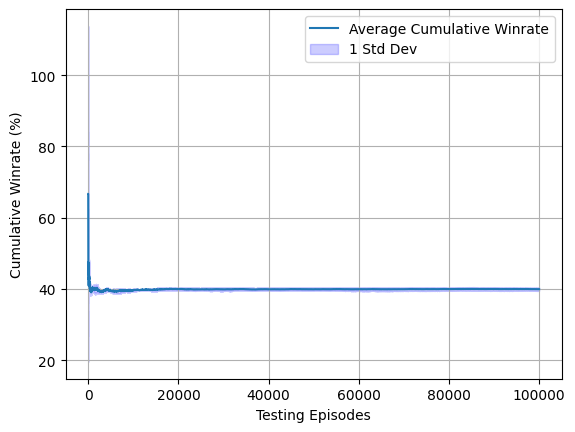

In [ ]:
test_episodes = np.arange(len(average_cum_winrate))

plt.plot(test_episodes, average_cum_winrate, label='Average Cumulative Winrate')

plt.fill_between(test_episodes,
                 average_cum_winrate - std_cum_winrate,
                 average_cum_winrate + std_cum_winrate,
                 color='blue', alpha=0.2, label='1 Std Dev')

plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/CumWinRateNoSplitFull.pdf', format='pdf', bbox_inches='tight')

plt.show()

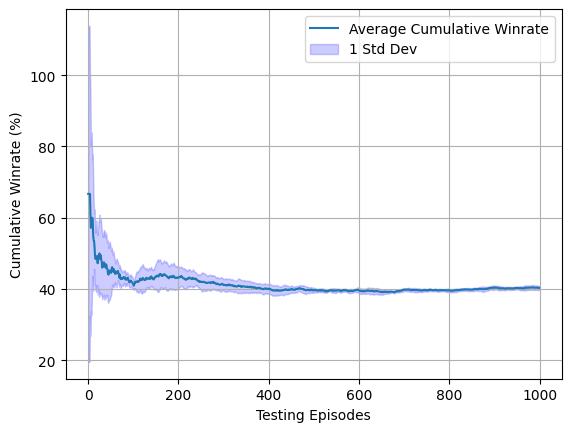

In [ ]:
truncation = 1000
test_episodes = np.arange(len(average_cum_winrate))

plt.plot(test_episodes[:truncation], average_cum_winrate[:truncation], label='Average Cumulative Winrate')

plt.fill_between(test_episodes[:truncation],
                 average_cum_winrate[:truncation] - std_cum_winrate[:truncation],
                 average_cum_winrate[:truncation] + std_cum_winrate[:truncation],
                 color='blue', alpha=0.2, label='1 Std Dev')

plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/CumWinRateNoSplitTrunc.pdf', format='pdf', bbox_inches='tight')

plt.show()

## With Splitting

In [ ]:
class BlackjackGame:

    heart = "\u2665"
    spade = "\u2660"
    diamond = "\u2666"
    club = "\u2663"

    suits = {
        "diamonds": diamond,
        "hearts": heart,
        "spades": spade,
        "clubs": club
    }

    def __init__(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hands = [[]]  # Multiple hands for splitting
        self.dealer_hand = []
        self.current_hand = 0

    @staticmethod
    def generate_deck():
        numbers = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        deck = [{'number': number, 'suit': suit} for number in numbers for suit in suits]
        return deck

    def deal_card(self):
        return self.deck.pop()

    def start_game(self):
        self.player_hands = [[self.deal_card(), self.deal_card()]]  # Start with one hand
        self.dealer_hand = [self.deal_card(), self.deal_card()]
        self.current_hand = 0

    @staticmethod
    def hand_value(hand):
        value = 0
        aces = 0
        for card in hand:
            if card['number'] in ['J', 'Q', 'K']:
                value += 10
            elif card['number'] == 'A':
                value += 11
                aces += 1
            else:
                value += int(card['number'])

        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def player_action(self, action):
        current_hand = self.player_hands[self.current_hand]
        if action == "hit":
            current_hand.append(self.deal_card())
        elif action == "split" and len(current_hand) == 2 and current_hand[0]['number'] == current_hand[1]['number']:
            self.player_hands.append([self.player_hands[self.current_hand].pop()])
            self.player_hands[self.current_hand].append(self.deal_card())
            self.player_hands[-1].append(self.deal_card())

        return self.game_status()

    def dealer_action(self, output=False):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deal_card())
            if output:
                print("Dealer hits and has:", self.format_cards(self.dealer_hand), self.hand_value(self.dealer_hand))

    def game_status(self):
        current_hand_value = self.hand_value(self.player_hands[self.current_hand])
        if current_hand_value > 21:
            return "player_bust"
        elif current_hand_value == 21:
            return "player_blackjack"
        else:
            return "continue"

    def game_result(self):
        self.dealer_action()
        results = []
        dealer_value = self.hand_value(self.dealer_hand)

        for hand in self.player_hands:
            player_value = self.hand_value(hand)
            if player_value > 21:
                results.append("loss")
            elif dealer_value > 21 or player_value > dealer_value:
                results.append("win")
            elif player_value == dealer_value:
                results.append("draw")
            else:
                results.append("loss")

        return results

    @staticmethod
    def format_cards(cards):
        result = ""
        for card in cards:
            suit = BlackjackGame.suits[card["suit"]]
            result += f"{card['number']}{suit} "

        return result.strip()

In [ ]:
class BlackjackQVLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.Q = np.zeros((33, 12, 2, 3))  # Player sum, dealer card, usable ace, action (hit, stay, split)
        self.V = np.zeros((33, 12, 2))     # Player sum, dealer card, usable ace

    def choose_action(self, player_sum, dealer_card, usable_ace, can_split):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(["hit", "stay", "split"]) if can_split else np.random.choice(["hit", "stay"])
        else:
            if can_split:
                action_idx = np.argmax(self.Q[player_sum, dealer_card, usable_ace])
                return ["hit", "stay", "split"][action_idx]
            else:
                action_idx = np.argmax(self.Q[player_sum, dealer_card, usable_ace, :2])
                return ["hit", "stay"][action_idx]

    def update(self, player_sum, dealer_card, usable_ace, action, reward, new_player_sum, new_dealer_card, new_usable_ace):
        action_idx = ["hit", "stay", "split"].index(action)
        old_q_value = self.Q[player_sum, dealer_card, usable_ace, action_idx]

        new_v_value = self.V[new_player_sum, new_dealer_card, new_usable_ace]
        old_v_value = self.V[player_sum, dealer_card, usable_ace]
        self.V[player_sum, dealer_card, usable_ace] = old_v_value + self.alpha * (reward + self.gamma * new_v_value - old_v_value)

        self.Q[player_sum, dealer_card, usable_ace, action_idx] = old_q_value + self.alpha * (reward + self.gamma * new_v_value - old_q_value)

    @staticmethod
    def has_usable_ace(hand):
        """Check if the hand has a usable ace."""
        value, ace = 0, False
        for card in hand:
            card_number = card['number']
            value += min(10, int(card_number) if card_number not in ['J', 'Q', 'K', 'A'] else 11)
            ace |= (card_number == 'A')
        return int(ace and value + 10 <= 21)

    def train(self, episodes):
        one_percent = round(episodes / 100)

        for ep in range(episodes):
            game = BlackjackGame()
            game.start_game()

            if ep % one_percent == 0:
                progress = (ep / episodes) * 100
                print(f"Training progress: {progress:.2f}%")

            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            status = "continue"

            while status == "continue":
                player_sum = game.hand_value(game.player_hands[game.current_hand])
                usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])
                can_split = len(game.player_hands[game.current_hand]) == 2 and game.player_hands[game.current_hand][0]['number'] == game.player_hands[game.current_hand][1]['number']
                action = self.choose_action(player_sum, dealer_card, usable_ace, can_split)
                status = game.player_action(action)
                new_player_sum = game.hand_value(game.player_hands[game.current_hand])
                new_usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])

                reward = 0  # Intermediate reward, only final matters

                if status == "player_blackjack":
                    reward = 1
                elif status == "player_bust":
                    reward = -1

                if reward != 0:
                    self.update(player_sum, dealer_card, usable_ace, action, reward, new_player_sum, dealer_card, new_usable_ace)

                if action == "stay":
                    game.current_hand += 1
                    if game.current_hand >= len(game.player_hands):
                        break

            final_results = game.game_result()
            for result in final_results:
                final_reward = 1 if result == "win" else (-1 if result == "loss" else 0)
                self.update(player_sum, dealer_card, usable_ace, action, final_reward, new_player_sum, dealer_card, new_usable_ace)

    def play(self):
        game = BlackjackGame()
        game.start_game()

        split_choices = 0
        split_opportunities = 0

        status = "continue"
        while status == "continue":
            player_sum = game.hand_value(game.player_hands[game.current_hand])
            usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])
            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            can_split = (
                len(game.player_hands[game.current_hand]) == 2 and
                game.player_hands[game.current_hand][0]['number'] == game.player_hands[game.current_hand][1]['number']
            )

            if can_split:
                split_opportunities += 1

            action = self.choose_action(player_sum, dealer_card, usable_ace, can_split)
            status = game.player_action(action)

            if action == "split":
              split_choices += 1

            if action == "stay":
                game.current_hand += 1
                if game.current_hand >= len(game.player_hands):
                    break

        final_results = game.game_result()

        return final_results, split_opportunities, split_choices

In [ ]:
def train_agent(alpha, gamma, episodes):
  agent_qv = BlackjackQVLearning(alpha=alpha, gamma=gamma)
  agent_qv.train(episodes)

  return agent_qv

In [ ]:
def test_agent(model, test_games):
  wins_qv = 0
  losses_qv = 0
  draws_qv = 0
  total_split_opportunities = 0
  total_split_choices = 0

  cum_winrate = []

  for idx in range(test_games):
      result, split_opportunities, split_choices = agent_qv.play()
      total_split_opportunities += split_opportunities
      total_split_choices += split_choices


      for outcome in result:
          if outcome == "win":
              wins_qv += 1
              cum_winrate.append(wins_qv/(wins_qv + losses_qv)*100)
          elif outcome == "loss":
              losses_qv += 1
              cum_winrate.append(wins_qv/(wins_qv + losses_qv)*100)
          else:
              draws_qv += 1

  split_rate = total_split_choices / total_split_opportunities * 100

  return cum_winrate, split_rate

In [ ]:
iterations = 3

cum_winrate_total = [[] for _ in range(iterations)]

split_rate_total = [[] for _ in range(iterations)]

for idx in range(iterations):
  np.random.seed(idx)
  agent_qv = train_agent(alpha=0.08, gamma=0.9, episodes=5000000)
  cum_winrate_tmp, split_rate_tmp = test_agent(model=agent_qv, test_games=100000)
  print(cum_winrate_tmp)

  cum_winrate_total[idx] = cum_winrate_tmp
  split_rate_total[idx] = split_rate_tmp


Training progress: 0.00%
Training progress: 1.00%
Training progress: 2.00%
Training progress: 3.00%
Training progress: 4.00%
Training progress: 5.00%
Training progress: 6.00%
Training progress: 7.00%
Training progress: 8.00%
Training progress: 9.00%
Training progress: 10.00%
Training progress: 11.00%
Training progress: 12.00%
Training progress: 13.00%
Training progress: 14.00%
Training progress: 15.00%
Training progress: 16.00%
Training progress: 17.00%
Training progress: 18.00%
Training progress: 19.00%
Training progress: 20.00%
Training progress: 21.00%
Training progress: 22.00%
Training progress: 23.00%
Training progress: 24.00%
Training progress: 25.00%
Training progress: 26.00%
Training progress: 27.00%
Training progress: 28.00%
Training progress: 29.00%
Training progress: 30.00%
Training progress: 31.00%
Training progress: 32.00%
Training progress: 33.00%
Training progress: 34.00%
Training progress: 35.00%
Training progress: 36.00%
Training progress: 37.00%
Training progress: 38.

In [ ]:
print(f'Average split rate: {np.mean(np.array(split_rate_total))}%')

Average split rate: 55.49681300540641%


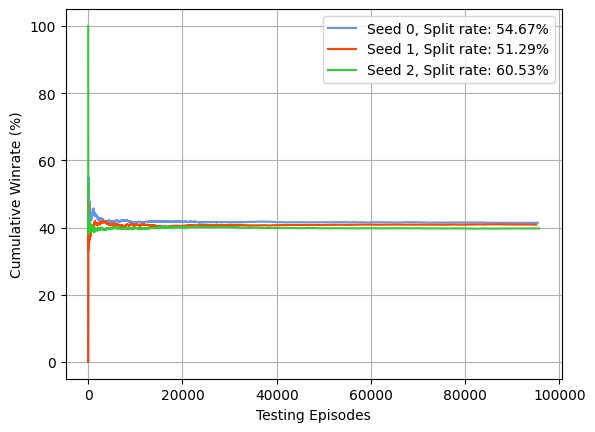

In [ ]:
test_episodes0 = np.arange(len(cum_winrate_total[0]))
test_episodes1 = np.arange(len(cum_winrate_total[1]))
test_episodes2 = np.arange(len(cum_winrate_total[2]))

plt.plot(test_episodes0, cum_winrate_total[0], label=f'Seed 0, Split rate: {split_rate_total[0]:.2f}%', c="cornflowerblue")
plt.plot(test_episodes1, cum_winrate_total[1], label=f'Seed 1, Split rate: {split_rate_total[1]:.2f}%', c="orangered")
plt.plot(test_episodes2, cum_winrate_total[2], label=f'Seed 2, Split rate: {split_rate_total[2]:.2f}%', c="limegreen")

plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/CumWinRateSplitFull-LR0.08-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

plt.show()

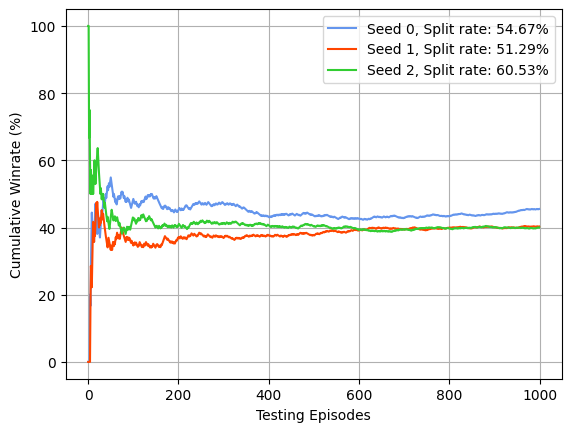

In [ ]:
truncation = 1000

test_episodes0 = np.arange(len(cum_winrate_total[0]))
test_episodes1 = np.arange(len(cum_winrate_total[1]))
test_episodes2 = np.arange(len(cum_winrate_total[2]))

plt.plot(test_episodes0[:truncation], cum_winrate_total[0][:truncation], label=f'Seed 0, Split rate: {split_rate_total[0]:.2f}%', c="cornflowerblue")
plt.plot(test_episodes1[:truncation], cum_winrate_total[1][:truncation], label=f'Seed 1, Split rate: {split_rate_total[1]:.2f}%', c="orangered")
plt.plot(test_episodes2[:truncation], cum_winrate_total[2][:truncation], label=f'Seed 2, Split rate: {split_rate_total[2]:.2f}%', c="limegreen")

plt.xlabel('Testing Episodes')
plt.ylabel('Cumulative Winrate (%)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ConstancaRL/CumWinRateSplitTrunc-LR0.08-Gamma0.9.pdf', format='pdf', bbox_inches='tight')

plt.show()

# Analyse Splitting

In [ ]:
class BlackjackGame:

    heart = "\u2665"
    spade = "\u2660"
    diamond = "\u2666"
    club = "\u2663"

    suits = {
        "diamonds": diamond,
        "hearts": heart,
        "spades": spade,
        "clubs": club
    }

    def __init__(self):
        self.deck = self.generate_deck()
        random.shuffle(self.deck)
        self.player_hands = [[]]  # Multiple hands for splitting
        self.dealer_hand = []
        self.current_hand = 0

    @staticmethod
    def generate_deck():
        numbers = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        deck = [{'number': number, 'suit': suit} for number in numbers for suit in suits]
        return deck

    def deal_card(self):
        return self.deck.pop()

    def start_game(self):
        self.player_hands = [[self.deal_card(), self.deal_card()]]  # Start with one hand
        self.dealer_hand = [self.deal_card(), self.deal_card()]
        self.current_hand = 0

    @staticmethod
    def hand_value(hand):
        value = 0
        aces = 0
        for card in hand:
            if card['number'] in ['J', 'Q', 'K']:
                value += 10
            elif card['number'] == 'A':
                value += 11
                aces += 1
            else:
                value += int(card['number'])

        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def player_action(self, action):
        current_hand = self.player_hands[self.current_hand]
        if action == "hit":
            current_hand.append(self.deal_card())
        elif action == "split" and len(current_hand) == 2 and current_hand[0]['number'] == current_hand[1]['number']:
            self.player_hands.append([self.player_hands[self.current_hand].pop()])
            self.player_hands[self.current_hand].append(self.deal_card())
            self.player_hands[-1].append(self.deal_card())

        return self.game_status()

    def dealer_action(self, output=False):
        while self.hand_value(self.dealer_hand) < 17:
            self.dealer_hand.append(self.deal_card())
            if output:
                print("Dealer hits and has:", self.format_cards(self.dealer_hand), self.hand_value(self.dealer_hand))

    def game_status(self):
        current_hand_value = self.hand_value(self.player_hands[self.current_hand])
        if current_hand_value > 21:
            return "player_bust"
        elif current_hand_value == 21:
            return "player_blackjack"
        else:
            return "continue"

    def game_result(self):
        self.dealer_action()
        results = []
        dealer_value = self.hand_value(self.dealer_hand)

        for hand in self.player_hands:
            player_value = self.hand_value(hand)
            if player_value > 21:
                results.append("loss")
            elif dealer_value > 21 or player_value > dealer_value:
                results.append("win")
            elif player_value == dealer_value:
                results.append("draw")
            else:
                results.append("loss")

        return results

    @staticmethod
    def format_cards(cards):
        result = ""
        for card in cards:
            suit = BlackjackGame.suits[card["suit"]]
            result += f"{card['number']}{suit} "

        return result.strip()

In [ ]:
class BlackjackQVLearning:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.Q = np.zeros((33, 12, 2, 3))  # Player sum, dealer card, usable ace, action (hit, stay, split)
        self.V = np.zeros((33, 12, 2))     # Player sum, dealer card, usable ace

    def choose_action(self, player_sum, dealer_card, usable_ace, can_split):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(["hit", "stay", "split"]) if can_split else np.random.choice(["hit", "stay"])
        else:
            if can_split:
                action_idx = np.argmax(self.Q[player_sum, dealer_card, usable_ace])
                return ["hit", "stay", "split"][action_idx]
            else:
                action_idx = np.argmax(self.Q[player_sum, dealer_card, usable_ace, :2])
                return ["hit", "stay"][action_idx]

    def update(self, player_sum, dealer_card, usable_ace, action, reward, new_player_sum, new_dealer_card, new_usable_ace):
        action_idx = ["hit", "stay", "split"].index(action)
        old_q_value = self.Q[player_sum, dealer_card, usable_ace, action_idx]

        new_v_value = self.V[new_player_sum, new_dealer_card, new_usable_ace]
        old_v_value = self.V[player_sum, dealer_card, usable_ace]
        self.V[player_sum, dealer_card, usable_ace] = old_v_value + self.alpha * (reward + self.gamma * new_v_value - old_v_value)

        self.Q[player_sum, dealer_card, usable_ace, action_idx] = old_q_value + self.alpha * (reward + self.gamma * new_v_value - old_q_value)

    @staticmethod
    def has_usable_ace(hand):
        """Check if the hand has a usable ace."""
        value, ace = 0, False
        for card in hand:
            card_number = card['number']
            value += min(10, int(card_number) if card_number not in ['J', 'Q', 'K', 'A'] else 11)
            ace |= (card_number == 'A')
        return int(ace and value + 10 <= 21)

    def train(self, episodes):
        one_percent = round(episodes / 100)

        for ep in range(episodes):
            game = BlackjackGame()
            game.start_game()

            if ep % one_percent == 0:
                progress = (ep / episodes) * 100
                print(f"Training progress: {progress:.2f}%")

            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            status = "continue"

            while status == "continue":
                player_sum = game.hand_value(game.player_hands[game.current_hand])
                usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])
                can_split = len(game.player_hands[game.current_hand]) == 2 and game.player_hands[game.current_hand][0]['number'] == game.player_hands[game.current_hand][1]['number']
                action = self.choose_action(player_sum, dealer_card, usable_ace, can_split)
                status = game.player_action(action)
                new_player_sum = game.hand_value(game.player_hands[game.current_hand])
                new_usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])

                reward = 0  # Intermediate reward, only final matters

                if status == "player_blackjack":
                    reward = 1
                elif status == "player_bust":
                    reward = -1

                if reward != 0:
                    self.update(player_sum, dealer_card, usable_ace, action, reward, new_player_sum, dealer_card, new_usable_ace)

                if action == "stay":
                    game.current_hand += 1
                    if game.current_hand >= len(game.player_hands):
                        break

            final_results = game.game_result()
            for result in final_results:
                final_reward = 1 if result == "win" else (-1 if result == "loss" else 0)
                self.update(player_sum, dealer_card, usable_ace, action, final_reward, new_player_sum, dealer_card, new_usable_ace)

    def play(self):
        game = BlackjackGame()
        game.start_game()

        split_choices = 0
        split_opportunities = 0

        # Initialize split card values with all possible cards
        split_card_values = {str(i): 0 for i in range(2, 11)}
        split_card_values.update({'J': 0, 'Q': 0, 'K': 0, 'A': 0})

        status = "continue"
        while status == "continue":
            player_sum = game.hand_value(game.player_hands[game.current_hand])
            usable_ace = self.has_usable_ace(game.player_hands[game.current_hand])
            dealer_card = int(game.dealer_hand[0]['number']) if game.dealer_hand[0]['number'] not in ['J', 'Q', 'K', 'A'] else (10 if game.dealer_hand[0]['number'] != 'A' else 11)
            can_split = (
                len(game.player_hands[game.current_hand]) == 2 and
                game.player_hands[game.current_hand][0]['number'] == game.player_hands[game.current_hand][1]['number']
            )

            if can_split:
                split_opportunities += 1
                card_value = game.player_hands[game.current_hand][0]['number']

            action = self.choose_action(player_sum, dealer_card, usable_ace, can_split)
            status = game.player_action(action)

            if action == "split":
                split_choices += 1
                split_card_values[card_value] += 1  # Track the frequency of splits for each card value

            if action == "stay":
                game.current_hand += 1
                if game.current_hand >= len(game.player_hands):
                    break

        final_results = game.game_result()

        return final_results, split_opportunities, split_choices, split_card_values

In [ ]:
agent_qv = BlackjackQVLearning(alpha=0.1, gamma=0.9)
agent_qv.train(5000000)

Training progress: 0.00%
Training progress: 1.00%
Training progress: 2.00%
Training progress: 3.00%
Training progress: 4.00%
Training progress: 5.00%
Training progress: 6.00%
Training progress: 7.00%
Training progress: 8.00%
Training progress: 9.00%
Training progress: 10.00%
Training progress: 11.00%
Training progress: 12.00%
Training progress: 13.00%
Training progress: 14.00%
Training progress: 15.00%
Training progress: 16.00%
Training progress: 17.00%
Training progress: 18.00%
Training progress: 19.00%
Training progress: 20.00%
Training progress: 21.00%
Training progress: 22.00%
Training progress: 23.00%
Training progress: 24.00%
Training progress: 25.00%
Training progress: 26.00%
Training progress: 27.00%
Training progress: 28.00%
Training progress: 29.00%
Training progress: 30.00%
Training progress: 31.00%
Training progress: 32.00%
Training progress: 33.00%
Training progress: 34.00%
Training progress: 35.00%
Training progress: 36.00%
Training progress: 37.00%
Training progress: 38.

In [ ]:
# Test the agent's performance
test_games = 100000
wins_qv = 0
losses_qv = 0
draws_qv = 0
total_split_opportunities = 0
total_split_choices = 0

# Initialize a dictionary to aggregate split card values across all games
total_split_card_values = {str(i): 0 for i in range(2, 11)}
total_split_card_values.update({'J': 0, 'Q': 0, 'K': 0, 'A': 0})

for idx in range(test_games):
    result, split_opportunities, split_choices, split_card_values = agent_qv.play()
    total_split_opportunities += split_opportunities
    total_split_choices += split_choices

    # Aggregate split card values
    for card_value, count in split_card_values.items():
        total_split_card_values[card_value] += count

    # Iterate over the results for each hand (including split hands)
    for outcome in result:
        if outcome == "win":
            wins_qv += 1
        elif outcome == "loss":
            losses_qv += 1
        else:
            draws_qv += 1

print(f"Wins: {wins_qv}, Losses: {losses_qv}, Draws: {draws_qv}")
print(f"Win rate: {wins_qv / (wins_qv + losses_qv) * 100:.2f}%")

# Output the split statistics
if total_split_opportunities > 0:
    print(f"Total split opportunities: {total_split_opportunities}")
    print(f"Total split choices: {total_split_choices}")
    print(f"Split percentage: {total_split_choices / total_split_opportunities * 100:.2f}%")
else:
    print("No split opportunities encountered during testing.")

# Display the split card values
print("Split card values frequency:")
for card_value, count in total_split_card_values.items():
    print(f"Card {card_value}: {count} splits")


# Convert card values to a sorted list for consistent ordering in the chart
card_values = list(total_split_card_values.keys())
split_frequencies = [total_split_card_values[card] for card in card_values]

Wins: 38553, Losses: 56904, Draws: 8031
Win rate: 40.39%
Total split opportunities: 6124
Total split choices: 3488
Split percentage: 56.96%
Split card values frequency:
Card 2: 22 splits
Card 3: 14 splits
Card 4: 14 splits
Card 5: 15 splits
Card 6: 422 splits
Card 7: 247 splits
Card 8: 217 splits
Card 9: 239 splits
Card 10: 450 splits
Card J: 453 splits
Card Q: 471 splits
Card K: 449 splits
Card A: 475 splits


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


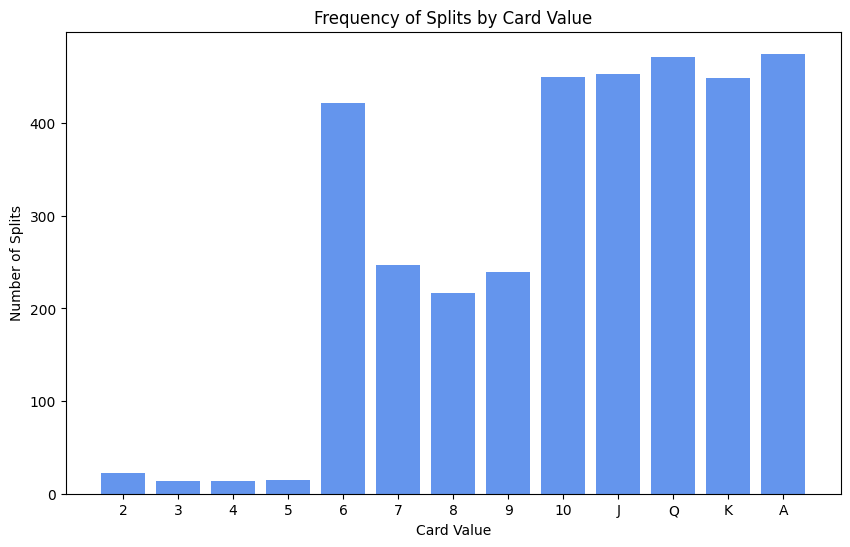

In [ ]:


from google.colab import drive
drive.mount('/content/drive')
plt.figure(figsize=(10, 6))
plt.bar(card_values, split_frequencies, color='cornflowerblue')
plt.xlabel('Card Value')
plt.ylabel('Number of Splits')
plt.title('Frequency of Splits by Card Value')
plt.savefig('/content/drive/MyDrive/ConstancaRL/SplittingStrategy.pdf', format='pdf', bbox_inches='tight')
plt.show()